**Reference :** spark.apache.org

**Release :** https://spark.apache.org/docs/latest/ml-guide.html

Spark MLLib

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=1eeb196059b7a3c5c0563bc267c52f761b01829cc8278eb25743adb0219c48ca
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession # SQL
from pyspark.ml.regression import LinearRegression # ML Library
from pyspark.ml.feature import VectorAssembler

In [3]:
spark = SparkSession.builder.appName('mllibExercise').getOrCreate()


In [42]:
# the data format is in libsbm format
data = spark.read.csv('/content/sample_data/Ecommerce-Customers.csv' , inferSchema=True, header=True)

In [47]:
data.head(1)

[Row(Email='mstephenson@fernandez.com', Address='835 Frank TunnelWrightmouth, MI 82180-9605', Avatar='Violet', Avg Session Length=34.49726772511229, Time on App=12.65565114916675, Time on Website=39.57766801952616, Length of Membership=4.0826206329529615, Yearly Amount Spent=587.9510539684005)]

In [46]:
data.show(10)

+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|               Email|             Address|          Avatar|Avg Session Length|       Time on App|   Time on Website|Length of Membership|Yearly Amount Spent|
+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616|  4.0826206329529615|  587.9510539684005|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|    2.66403418213262|  392.2049334443264|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37.110597442120856|   4.104543202376424| 487.54750486747207|
|riverarebecca@gma...|1414 David Throug...|   

# Data analysis
### The labels are the dependant variable / target to be detected
### Features are the inputs / independant variables for model training

Independant variable / Label to be predicted is: Yearlt amount Spent

Predictor Variables:
Email, Address , Time spent on App, session


In [45]:
data.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)



In [51]:
data.columns

['Email',
 'Address',
 'Avatar',
 'Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership',
 'Yearly Amount Spent']

#Feature engineering

In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

In [52]:
# Convert group of features into single vector
vector_assembler = VectorAssembler(inputCols=['Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership'], outputCol='features')

In [56]:
# This step is to combines the combined feature to the original dataset
collated_data = vector_assembler.transform(data)

In [57]:
collated_data.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)
 |-- features: vector (nullable = true)



# The model is going to be trained only on the feature vector obtained from

'Avg Session Length', 'Time on App', 'Time on Website'

In [60]:
finalDf = collated_data.select('features', 'Yearly Amount Spent')
finalDf.show()

+--------------------+-------------------+
|            features|Yearly Amount Spent|
+--------------------+-------------------+
|[34.4972677251122...|  587.9510539684005|
|[31.9262720263601...|  392.2049334443264|
|[33.0009147556426...| 487.54750486747207|
|[34.3055566297555...|  581.8523440352177|
|[33.3306725236463...|  599.4060920457634|
|[33.8710378793419...|   637.102447915074|
|[32.0215955013870...|  521.5721747578274|
|[32.7391429383803...|  549.9041461052942|
|[33.9877728956856...|  570.2004089636196|
|[31.9365486184489...|  427.1993848953282|
|[33.9925727749537...|  492.6060127179966|
|[33.8793608248049...|  522.3374046069357|
|[29.5324289670579...|  408.6403510726275|
|[33.1903340437226...|  573.4158673313865|
|[32.3879758531538...|  470.4527333009554|
|[30.7377203726281...|  461.7807421962299|
|[32.1253868972878...| 457.84769594494855|
|[32.3388993230671...| 407.70454754954415|
|[32.1878120459321...|  452.3156754800354|
|[32.6178560628234...|   605.061038804892|
+----------

In [72]:
train , test = finalDf.randomSplit([0.7,0.3])

In [62]:
train.describe().show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                338|
|   mean|  498.1449660114984|
| stddev|   77.4022309146557|
|    min|   266.086340948469|
|    max|  765.5184619388373|
+-------+-------------------+



In [64]:
test.describe().show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                162|
|   mean|  501.7532136877085|
| stddev|  83.35727796979623|
|    min| 256.67058229005585|
|    max|  725.5848140556806|
+-------+-------------------+



In [73]:
lr = LinearRegression(featuresCol='features' , labelCol='Yearly Amount Spent',
                      predictionCol='prediction')

In [74]:
# Model training
lrModel = lr.fit(train)

In [75]:
test_result = lrModel.evaluate(test)

In [103]:
test_result.predictions['prediction']

Column<'prediction'>

In [77]:
test_result.residuals.show()

+-------------------+
|          residuals|
+-------------------+
| -5.411854956991249|
| 10.539407854088836|
|-17.158147809503475|
|-4.3986003252336445|
| -6.113488704651502|
|  19.28002583542076|
|  4.012612182229873|
| 0.9346491248456914|
| -3.872653016340564|
| -4.080648273885174|
|-1.7496789968853363|
| 2.6364625027234183|
|-4.3486819675895845|
|-10.978967495981806|
| -2.137168655474113|
|  8.232116237560206|
|-2.2193027765981697|
| -10.47733188874247|
|-17.004490737250137|
| -5.319359377992328|
+-------------------+
only showing top 20 rows



In [79]:
training_summary = lrModel.summary

In [80]:
training_summary.meanAbsoluteError

7.93192147116849

In [81]:
training_summary.rootMeanSquaredError

10.063487236560018

In [82]:
training_summary.r2

0.9840075050328214

In [85]:
finalDf.show(10)

+--------------------+-------------------+
|            features|Yearly Amount Spent|
+--------------------+-------------------+
|[34.4972677251122...|  587.9510539684005|
|[31.9262720263601...|  392.2049334443264|
|[33.0009147556426...| 487.54750486747207|
|[34.3055566297555...|  581.8523440352177|
|[33.3306725236463...|  599.4060920457634|
|[33.8710378793419...|   637.102447915074|
|[32.0215955013870...|  521.5721747578274|
|[32.7391429383803...|  549.9041461052942|
|[33.9877728956856...|  570.2004089636196|
|[31.9365486184489...|  427.1993848953282|
+--------------------+-------------------+
only showing top 10 rows



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas DataFrame
residuals_df = test_result.residuals
type(residuals_df)

In [167]:
# Convert to Pandas DataFrame
residual_df = residuals_df.toPandas()
pandas_df = test_result.predictions.toPandas()

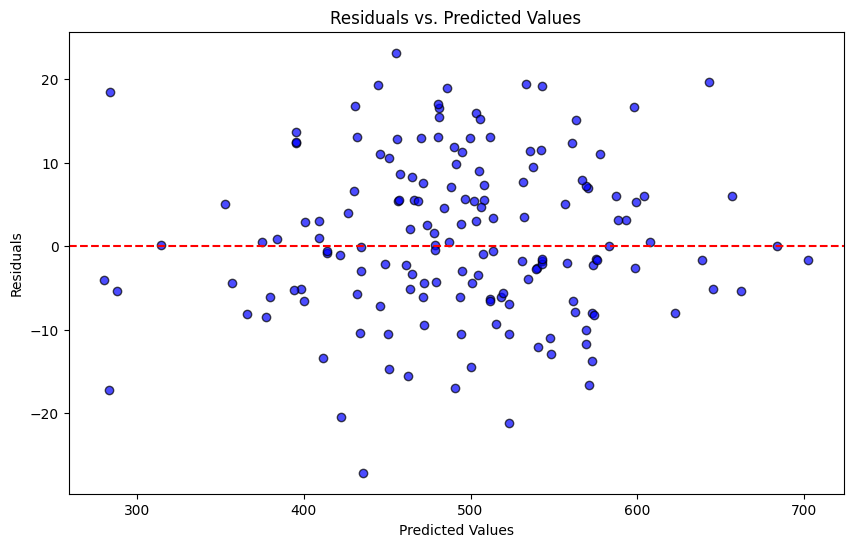

In [168]:
# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['prediction'], residual_df['residuals'], color="blue", edgecolor="k", alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()
